In [1]:
import numpy as np
import mne

Option 1: Detect events in the raw EEG file and apply the correction at each TR event

In [24]:
class GradientArtefactCorrection():

    def __init__(self):
        pass

    def fit_transform(self, raw, event_name, half_window_size=10):

        tr_events, event_id = mne.events_from_annotations(raw, event_id='auto', regexp=event_name, use_rounding=True, chunk_duration=None, verbose=None)

        tr = np.diff(tr_events[:,0])
        tr = np.mean(tr).astype(int)
        tr_s = tr / raw.info['sfreq']

        epochs = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr_s, baseline=None, preload=True)
        epochs_detrended = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr_s, baseline=None, preload=True, detrend=0)
        
        corrected = raw.get_data()
        for t,tr_event in enumerate(tr_events[:,0]):
            start = tr_event
            stop = start + tr + 1
            if stop > raw.n_times:
                stop = raw.n_times

            indice_min = t - half_window_size 
            indice_max = t + half_window_size + 1

            # Manage edge cases
            if t < half_window_size:
                indice_min = 0
                indice_max = 2 * half_window_size + 1

            if t > len(epochs) - half_window_size:
                indice_max = len(epochs)
                indice_min = len(epochs) - 2 * half_window_size - 1

            template = epochs_detrended[indice_min:indice_max].average(picks='all').data
            data = epochs[t].get_data()[0]
            corrected[:, start:stop] = data - template

        raw_corrected = mne.io.RawArray(corrected, raw.info)
        raw_corrected.set_annotations(raw.annotations)
        return(raw_corrected)


Extracting parameters from D:\Soraya\P01_eyes_closed_mrion.vhdr...
Setting channel info structure...
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated
Loading data for 331 events and 4000 original time points ...
0 bad epochs dropped
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2582670247.py:6: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs.plot_image(picks=["Fp1"])


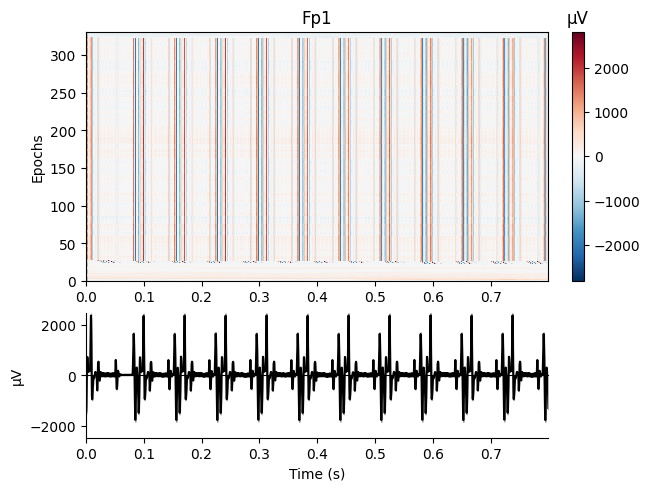

In [25]:
raw = mne.io.read_raw_brainvision(r'D:\Soraya\P01_eyes_closed_mrion.vhdr')

tr = 0.8

epochs = mne.make_fixed_length_epochs(raw, duration=tr, overlap=0, preload=True)
event_related_plot = epochs.plot_image(picks=["Fp1"])

Used Annotations descriptions: ['Response/R128']
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Loading data for 291 events and 4001 original time points ...
0 bad epochs dropped
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Loading data for 291 events and 4001 original time points ...
0 bad epochs dropped


C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2111721610.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs[t].get_data()[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2111721610.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs[t].get_data()[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2111721610.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs[t].get_data()[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2111721610.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs[t].get_data()[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\211

Creating RawArray with float64 data, n_channels=32, n_times=1326800
    Range : 0 ... 1326799 =      0.000 ...   265.360 secs
Ready.
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 331 events and 4000 original time points ...


C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2111721610.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs[t].get_data()[0]


0 bad epochs dropped
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\2831706496.py:5: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs.plot_image(picks=["Fp1"])


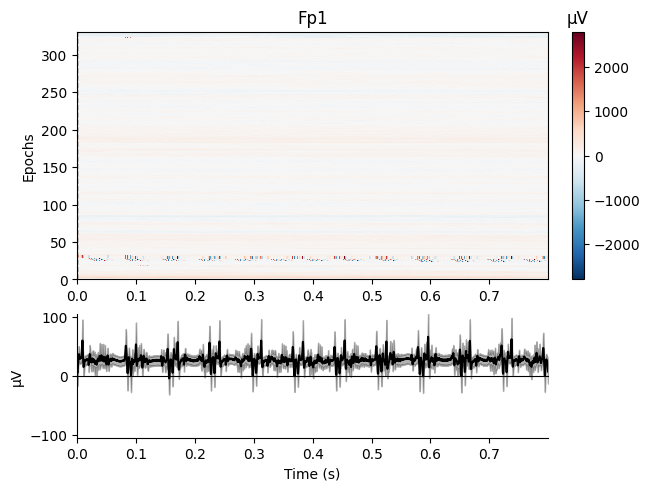

In [26]:
GAC = GradientArtefactCorrection()
raw_ga = GAC.fit_transform(raw, event_name='Response/R128', half_window_size=20)

epochs = mne.make_fixed_length_epochs(raw_ga, duration=tr, overlap=0, preload=True)
event_related_plot = epochs.plot_image(picks=["Fp1"])

Option 2: Cut the EEG recording on non overlapping epochs of length TR

In [16]:
class GradientArtefactCorrection():

    def __init__(self):
        pass

    def fit_transform(self, raw, tr, half_window_size=10):

        event_id = 1
        tr_events = mne.make_fixed_length_events(raw, id=event_id, duration=tr)
        epochs = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr, baseline=None, preload=True)
        epochs_detrended = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr, baseline=None, preload=True, detrend=0)
        
        tr_nsamples = int(tr * raw.info['sfreq'])
        corrected = raw.get_data()
        for t,tr_event in enumerate(tr_events[:,0]):
            start = tr_event
            stop = start + tr_nsamples + 1
            if stop > raw.n_times:
                stop = raw.n_times

            indice_min = t - half_window_size 
            indice_max = t + half_window_size + 1

            # Manage edge cases
            if t < half_window_size:
                indice_min = 0
                indice_max = 2 * half_window_size + 1

            if t > len(epochs) - half_window_size:
                indice_max = len(epochs)
                indice_min = len(epochs) - 2 * half_window_size - 1

            template = epochs_detrended[indice_min:indice_max].average(picks='all').data
            data = epochs[t].get_data()[0]
            corrected[:, start:stop] = data - template

        raw_corrected = mne.io.RawArray(corrected, raw.info)
        raw_corrected.set_annotations(raw.annotations)
        return(raw_corrected)

Extracting parameters from D:\Soraya\P01_eyes_closed_mrion.vhdr...
Setting channel info structure...
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated
Loading data for 331 events and 4000 original time points ...
0 bad epochs dropped
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_2352\3189761066.py:5: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs.plot_image(picks=["Fp1"])


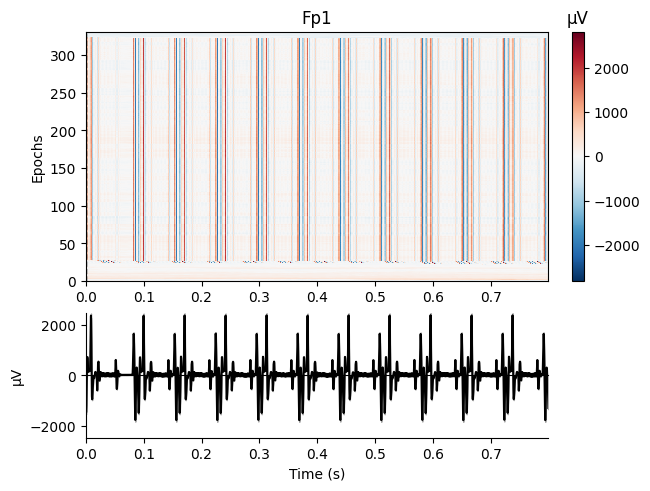

In [18]:
raw = mne.io.read_raw_brainvision(r'D:\Soraya\P01_eyes_closed_mrion.vhdr')
tr = 0.8

epochs = mne.make_fixed_length_epochs(raw, duration=tr, overlap=0, preload=True)
event_related_plot = epochs.plot_image(picks=["Fp1"])

In [ ]:
GAC = GradientArtefactCorrection()
raw_ga = GAC.fit_transform(raw, tr=tr, half_window_size=20)

epochs = mne.make_fixed_length_epochs(raw_ga, duration=tr, overlap=0, preload=True)
event_related_plot = epochs.plot_image(picks=["Fp1"])